In [10]:
from __future__ import print_function
from collections import OrderedDict
import os
import matplotlib.pyplot as plt
import torch
import copy
import _pickle as pkl
torch.manual_seed(0)

In [11]:
class Parse():
    def __init__(self):
        self.dataset = 'conll'
        self.result_path = 'neural_ner/results'
        self.usemodel = 'CNN_BiLSTM_CRF'
        self.worddim = 300
        self.pretrnd = 'wordvectors/hi.vec'
        self.reload = 0
        self.checkpoint = '.'
        self.num_epochs = 20
        self.initdata = 2
        self.acquiremethod = 'random'
        self.gpu = 0

opt=Parse()

In [12]:
from __future__ import print_function
import os
import re
import numpy as np
np.random.seed(0)
import codecs
import random
random.seed(0)

START_TAG = '<START>'
STOP_TAG = '<STOP>'

def get_name(parameters):
    """
    Generate a model name from its parameters.
    """
    l = []
    for k, v in parameters.items():
        if type(v) is str and "/" in v:
            l.append((k, v[::-1][:v[::-1].index('/')][::-1]))
        else:
            l.append((k, v))
    name = ",".join(["%s=%s" % (k, str(v).replace(',', '')) for k, v in l])
    return "".join(i for i in name if i not in "\/:*?<>|")


def set_values(name, param, pretrained):
    """
    Initialize a network parameter with pretrained values.
    We check that sizes are compatible.
    """
    param_value = param.get_value()
    if pretrained.size != param_value.size:
        raise Exception(
            "Size mismatch for parameter %s. Expected %i, found %i."
            % (name, param_value.size, pretrained.size)
        )
    param.set_value(np.reshape(
        pretrained, param_value.shape).astype(np.float32))


def create_dico(item_list):
    """
    Create a dictionary of items from a list of list of items.
    """
    assert type(item_list) is list
    dico = {}
    for items in item_list:
        for item in items:
            if item not in dico:
                dico[item] = 1
            else:
                dico[item] += 1
    return dico


def create_mapping(dico):
    """
    Create a mapping (item to ID / ID to item) from a dictionary.
    Items are ordered by decreasing frequency.
    """
    sorted_items = sorted(dico.items(), key=lambda x: (-x[1], x[0]))
    id_to_item = {i: v[0] for i, v in enumerate(sorted_items)}
    item_to_id = {v: k for k, v in id_to_item.items()}
    return item_to_id, id_to_item


def zero_digits(s):
    """
    Replace every digit in a string by a zero.
    """
    return re.sub('\d', '0', s)


def iob2(tags):
    """
    Check that tags have a valid IOB format.
    Tags in IOB1 format are converted to IOB2.
    """
    for i, tag in enumerate(tags):
        if tag == 'O':
            continue
        split = tag.split('-')
        if len(split) != 2 or split[0] not in ['I', 'B']:
            return False
        if split[0] == 'B':
            continue
        elif i == 0 or tags[i - 1] == 'O':  # conversion IOB1 to IOB2
            tags[i] = 'B' + tag[1:]
        elif tags[i - 1][1:] == tag[1:]:
            continue
        else:  # conversion IOB1 to IOB2
            tags[i] = 'B' + tag[1:]
    return True


def iob_iobes(tags):
    """
    IOB -> IOBES
    """
    new_tags = []
    for i, tag in enumerate(tags):
        if tag == 'O':
            new_tags.append(tag)
        elif tag.split('-')[0] == 'B':
            if i + 1 != len(tags) and \
               tags[i + 1].split('-')[0] == 'I':
                new_tags.append(tag)
            else:
                new_tags.append(tag.replace('B-', 'S-'))
        elif tag.split('-')[0] == 'I':
            if i + 1 < len(tags) and \
                    tags[i + 1].split('-')[0] == 'I':
                new_tags.append(tag)
            else:
                new_tags.append(tag.replace('I-', 'E-'))
        else:
            raise Exception('Invalid IOB format!')
    return new_tags


def iobes_iob(tags):
    """
    IOBES -> IOB
    """
    new_tags = []
    for i, tag in enumerate(tags):
        if tag.split('-')[0] == 'B':
            new_tags.append(tag)
        elif tag.split('-')[0] == 'I':
            new_tags.append(tag)
        elif tag.split('-')[0] == 'S':
            new_tags.append(tag.replace('S-', 'B-'))
        elif tag.split('-')[0] == 'E':
            new_tags.append(tag.replace('E-', 'I-'))
        elif tag.split('-')[0] == 'O':
            new_tags.append(tag)
        else:
            raise Exception('Invalid format!')
    return new_tags


def insert_singletons(words, singletons, p=0.5):
    """
    Replace singletons by the unknown word with a probability p.
    """
    new_words = []
    for word in words:
        if word in singletons and np.random.uniform() < p:
            new_words.append(0)
        else:
            new_words.append(word)
    return new_words


def pad_word_chars(words):
    """
    Pad the characters of the words in a sentence.
    Input:
        - list of lists of ints (list of words, a word being a list of char indexes)
    Output:
        - padded list of lists of ints
        - padded list of lists of ints (where chars are reversed)
        - list of ints corresponding to the index of the last character of each word
    """
    max_length = max([len(word) for word in words])
    char_for = []
    char_rev = []
    char_pos = []
    for word in words:
        padding = [0] * (max_length - len(word))
        char_for.append(word + padding)
        char_rev.append(word[::-1] + padding)
        char_pos.append(len(word) - 1)
    return char_for, char_rev, char_pos


def create_input(data, parameters, add_label, singletons=None):
    """
    Take sentence data and return an input for
    the training or the evaluation function.
    """
    words = data['words']
    chars = data['chars']
    if singletons is not None:
        words = insert_singletons(words, singletons)
    if parameters['cap_dim']:
        caps = data['caps']
    char_for, char_rev, char_pos = pad_word_chars(chars)
    input = []
    if parameters['word_dim']:
        input.append(words)
    if parameters['char_dim']:
        input.append(char_for)
        if parameters['char_bidirect']:
            input.append(char_rev)
        input.append(char_pos)
    if parameters['cap_dim']:
        input.append(caps)
    if add_label:
        input.append(data['tags'])
    return input

def char_mapping(sentences):
    """
    Create a dictionary and mapping of characters, sorted by frequency.
    """
    chars = ["".join([w[0] for w in s]) for s in sentences]
    dico = create_dico(chars)
    dico['<PAD>'] = 10000000
    # dico[';'] = 0
    char_to_id, id_to_char = create_mapping(dico)
    print("Found %i unique characters" % len(dico))
    return dico, char_to_id, id_to_char


def tag_mapping(sentences):
    """
    Create a dictionary and a mapping of tags, sorted by frequency.
    """
    tags = [[word[-1] for word in s] for s in sentences]
    dico = create_dico(tags)
    dico[START_TAG] = -1
    dico[STOP_TAG] = -2
    tag_to_id, id_to_tag = create_mapping(dico)
    print("Found %i unique named entity tags" % len(dico))
    return dico, tag_to_id, id_to_tag


def cap_feature(s):
    """
    Capitalization feature:
    0 = low caps
    1 = all caps
    2 = first letter caps
    3 = one capital (not first letter)
    """
    if s.lower() == s:
        return 0
    elif s.upper() == s:
        return 1
    elif s[0].upper() == s[0]:
        return 2
    else:
        return 3


def prepare_sentence(str_words, word_to_id, char_to_id, lower=False):
    """
    Prepare a sentence for evaluation.
    """
    def f(x): return x.lower() if lower else x
    words = [word_to_id[f(w) if f(w) in word_to_id else '<UNK>']
             for w in str_words]
    chars = [[char_to_id[c] for c in w if c in char_to_id]
             for w in str_words]
    caps = [cap_feature(w) for w in str_words]
    return {
        'str_words': str_words,
        'words': words,
        'chars': chars,
        'caps': caps
    }


def prepare_dataset(sentences, word_to_id, char_to_id, tag_to_id, lower=True):
    """
    Prepare the dataset. Return a list of lists of dictionaries containing:
        - word indexes
        - word char indexes
        - tag indexes
    """
    def f(x): return x.lower() if lower else x
    data = []
    for s in sentences:
        str_words = [w[0] for w in s]
        words = [word_to_id[f(w) if f(w) in word_to_id else '<UNK>']
                 for w in str_words]
        # Skip characters that are not in the training set
        chars = [[char_to_id[c] for c in w if c in char_to_id]
                 for w in str_words]
        caps = [cap_feature(w) for w in str_words]
        tags = [tag_to_id[w[-1]] for w in s]
        data.append({
            'str_words': str_words,
            'words': words,
            'chars': chars,
            'caps': caps,
            'tags': tags,
        })
    return data


def augment_with_pretrained(dictionary, ext_emb_path, words):
    """
    Augment the dictionary with words that have a pretrained embedding.
    If `words` is None, we add every word that has a pretrained embedding
    to the dictionary, otherwise, we only add the words that are given by
    `words` (typically the words in the development and test sets.)
    """
    print('Loading pretrained embeddings from %s...' % ext_emb_path)
    assert os.path.isfile(ext_emb_path)

    # Load pretrained embeddings from file
    pretrained = set([
        line.rstrip().split()[0].strip()
        for line in codecs.open(ext_emb_path, 'r', 'utf-8')
        if len(ext_emb_path) > 0
    ])
    
    if words is None:
        for word in pretrained:
            if word not in dictionary:
                dictionary[word] = 0
    else:
        for word in words:
            if any(x in pretrained for x in [
                word,
                word.lower(),
                re.sub('\d', '0', word.lower())
            ]) and word not in dictionary:
                dictionary[word] = 0

    word_to_id, id_to_word = create_mapping(dictionary)
    return dictionary, word_to_id, id_to_word


def pad_seq(seq, max_length, PAD_token=0):
    
    seq += [PAD_token for i in range(max_length - len(seq))]
    return seq

def log_sum_exp(vec, dim=-1, keepdim = False):
    max_score, _ = vec.max(dim, keepdim=keepdim)
    if keepdim:
        stable_vec = vec - max_score
    else:
        stable_vec = vec - max_score.unsqueeze(dim)
    output = max_score + (stable_vec.exp().sum(dim, keepdim=keepdim)).log()
    return output

def create_batches(dataset, batch_size, order='keep', str_words=False, tag_padded= True):
    
        newdata = copy.deepcopy(dataset)
        if order=='sort':
            newdata.sort(key = lambda x:len(x['words']))
        elif order=='random':
            random.shuffle(newdata)
        
        newdata = np.array(newdata)  
        batches = []
        num_batches = np.ceil(len(dataset)/float(batch_size)).astype('int')
        
        for i in range(num_batches):
            batch_data = newdata[(i*batch_size):min(len(dataset),(i+1)*batch_size)]
            
            words_seqs = [itm['words'] for itm in batch_data]
            caps_seqs = [itm['caps'] for itm in batch_data]
            target_seqs = [itm['tags'] for itm in batch_data]
            chars_seqs = [itm['chars'] for itm in batch_data]
            str_words_seqs = [itm['str_words'] for itm in batch_data]
            
            seq_pairs = sorted(zip(words_seqs, caps_seqs, target_seqs, chars_seqs, str_words_seqs), 
                               key=lambda p: len(p[0]), reverse=True)
            
            words_seqs, caps_seqs, target_seqs, chars_seqs, str_words_seqs = zip(*seq_pairs)
            words_lengths = np.array([len(s) for s in words_seqs])
            
            words_padded = np.array([pad_seq(s, np.max(words_lengths)) for s in words_seqs])
            caps_padded = np.array([pad_seq(s, np.max(words_lengths)) for s in caps_seqs])
            
            if tag_padded:
                target_padded = np.array([pad_seq(s, np.max(words_lengths)) for s in target_seqs])
            else:
                target_padded = target_seqs
            
            words_mask = (words_padded!=0).astype('int')
            
            chars_pseqs = [pad_seq(s, max(words_lengths), []) for s in chars_seqs]
            chars_lengths = np.array([[len(s) for s in w] for w in chars_pseqs]).reshape(-1)
            chars_padded = np.array([[pad_seq(s, np.max(chars_lengths)) 
                                      for s in w] for w in chars_pseqs]).reshape(-1,np.max(chars_lengths))
    
            if str_words:
                outputdict = {'words':words_padded, 'caps':caps_padded, 'tags': target_padded, 
                              'chars': chars_padded, 'wordslen': words_lengths, 'charslen': chars_lengths,
                              'tagsmask':words_mask, 'str_words': str_words_seqs}
            else:
                outputdict = {'words':words_padded, 'caps':caps_padded, 'tags': target_padded, 
                              'chars': chars_padded, 'wordslen': words_lengths, 'charslen': chars_lengths,
                              'tagsmask':words_mask}
            
            batches.append(outputdict)
        
        return batches

In [13]:
import torch.nn as nn
from torch.nn import init
import numpy as np

class Initializer(object):
    
    def __init__(self):
        pass
    
    def init_embedding(self, input_embedding):
        bias = np.sqrt(3.0 / input_embedding.size(1))
        nn.init.uniform(input_embedding, -bias, bias)
    
    def init_linear(self, input_linear):
        bias = np.sqrt(6.0 / (input_linear.weight.size(0) + input_linear.weight.size(1)))
        nn.init.uniform(input_linear.weight, -bias, bias)
        if input_linear.bias is not None:
            input_linear.bias.data.zero_()
    
    def init_lstm(self, input_lstm):
        for ind in range(0, input_lstm.num_layers):
            weight = eval('input_lstm.weight_ih_l' + str(ind))
            bias = np.sqrt(6.0 / (weight.size(0) / 4 + weight.size(1)))
            nn.init.uniform(weight, -bias, bias)
            weight = eval('input_lstm.weight_hh_l' + str(ind))
            bias = np.sqrt(6.0 / (weight.size(0) / 4 + weight.size(1)))
            nn.init.uniform(weight, -bias, bias)
        
        if input_lstm.bidirectional:
            for ind in range(0, input_lstm.num_layers):
                weight = eval('input_lstm.weight_ih_l' + str(ind) + '_reverse')
                bias = np.sqrt(6.0 / (weight.size(0) / 4 + weight.size(1)))
                nn.init.uniform(weight, -bias, bias)
                weight = eval('input_lstm.weight_hh_l' + str(ind) + '_reverse')
                bias = np.sqrt(6.0 / (weight.size(0) / 4 + weight.size(1)))
                nn.init.uniform(weight, -bias, bias)
        
        if input_lstm.bias:
            
            for ind in range(0, input_lstm.num_layers):
                weight = eval('input_lstm.bias_ih_l' + str(ind))
                weight.data.zero_()
                weight.data[input_lstm.hidden_size: 2 * input_lstm.hidden_size] = 1
                weight = eval('input_lstm.bias_hh_l' + str(ind))
                weight.data.zero_()
                weight.data[input_lstm.hidden_size: 2 * input_lstm.hidden_size] = 1
            
            if input_lstm.bidirectional:
                for ind in range(0, input_lstm.num_layers):
                    weight = eval('input_lstm.bias_ih_l' + str(ind) + '_reverse')
                    weight.data.zero_()
                    weight.data[input_lstm.hidden_size: 2 * input_lstm.hidden_size] = 1
                    weight = eval('input_lstm.bias_hh_l' + str(ind) + '_reverse')
                    weight.data.zero_()
                    weight.data[input_lstm.hidden_size: 2 * input_lstm.hidden_size] = 1

In [14]:
from __future__ import print_function
import os
import torch
torch.manual_seed(0)
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
#from .utils import *
import codecs
import _pickle
import itertools

class Loader(object):
    
    def __init__(self):
        pass
    
    def pad_sequence_cnn(self, chars):
        d = {}
        chars_length = [len(c) for c in chars]
        chars_maxlen = max(chars_length)
        chars_mask = np.zeros((len(chars_length), chars_maxlen), dtype='int')
        for i, c in enumerate(chars):
            chars_mask[i, :chars_length[i]] = c
        return chars_mask, chars_length, d
    
    
    def pad_sequence_rnn(self, chars):
        chars_sorted = sorted(chars, key=lambda p: len(p), reverse=True)
        d = {}
        for i, ci in enumerate(chars):
            for j, cj in enumerate(chars_sorted):
                if ci == cj and not j in d and not i in d.values():
                    d[j] = i
                    continue
        chars_length = [len(c) for c in chars_sorted]
        chars_maxlen = max(chars_length)
        chars_mask = np.zeros((len(chars_sorted), char_maxlen), dtype='int')
        for i, c in enumerate(chars_sorted):
            chars_mask[i, :chars_length[i]] = c
        return chars_mask, chars_length, d
    
    def update_tag_scheme(self, sentences, tag_scheme):
        
        for i, s in enumerate(sentences):
            tags = [w[-1] for w in s]
            if not iob2(tags):
                s_str = '\n'.join(' '.join(w) for w in s)
                raise Exception('Sentences should be given in IOB format! ' +
                                'Please check sentence %i:\n%s' % (i, s_str))
            if tag_scheme == 'iob':
                for word, new_tag in zip(s, tags):
                    word[-1] = new_tag
            elif tag_scheme == 'iobes':
                new_tags = iob_iobes(tags)
                for word, new_tag in zip(s, new_tags):
                    word[-1] = new_tag
            else:
                raise Exception('Unknown tagging scheme!')
                
    def word_mapping(self, sentences, lower):
        
        words = [[x[0].lower() if lower else x[0] for x in s] for s in sentences]
        dico = create_dico(words)

        dico['<PAD>'] = 10000001
        dico['<UNK>'] = 10000000
        dico = {k:v for k,v in dico.items() if v>=3}
        word_to_id, id_to_word = create_mapping(dico)

        print("Found %i unique words (%i in total)" % (
            len(dico), sum(len(x) for x in words)
        ))
        return dico, word_to_id, id_to_word
    
    def load_conll_sentences(self, path, lower, zeros):
        
        sentences = []
        sentence = []
        for line in codecs.open(path, 'r', 'utf-8'):
            line = zero_digits(line.rstrip()) if zeros else line.rstrip()
            if not line:
                if len(sentence) > 0:
                    if 'DOCSTART' not in sentence[0][0]:
                        sentences.append(sentence)
                    sentence = []
            else:
                word = line.split()
                assert len(word) >= 2
                sentence.append(word)
        if len(sentence) > 0:
            if 'DOCSTART' not in sentence[0][0]:
                sentences.append(sentence)
        return sentences
    
    def load_conll(self, dataset, parameters):
        
        zeros = parameters['zeros']
        lower = parameters['lower']
        word_dim = parameters['wrdim']
        pretrained = parameters['ptrnd']
        tag_scheme = parameters['tgsch']
        
        train_path = os.path.join(dataset, 'train.txt').replace('\\', '/')
        dev_path = os.path.join(dataset, 'testa.txt').replace('\\', '/')
        test_path = os.path.join(dataset, 'testb.txt').replace('\\', '/')
        test_train_path = os.path.join(dataset, 'testc.txt').replace('\\', '/')
        
        train_sentences = self.load_conll_sentences(train_path, lower, zeros)
        dev_sentences = self.load_conll_sentences(dev_path, lower, zeros)
        test_sentences = self.load_conll_sentences(test_path, lower, zeros)
        test_train_sentences = self.load_conll_sentences(test_train_path, lower, zeros)
        
        self.update_tag_scheme(train_sentences, tag_scheme)
        self.update_tag_scheme(dev_sentences, tag_scheme)
        self.update_tag_scheme(test_sentences, tag_scheme)
        self.update_tag_scheme(test_train_sentences, tag_scheme)
        
        dico_words_train = self.word_mapping(train_sentences, lower)[0]
        print(dico_words_train)
        
        all_embedding = 1
        dico_words, word_to_id, id_to_word = augment_with_pretrained(
                dico_words_train.copy(),
                pretrained,
                list(itertools.chain.from_iterable(
                    [[w[0] for w in s] for s in dev_sentences + test_sentences])
                ) if not all_embedding else None)

        dico_chars, char_to_id, id_to_char = char_mapping(train_sentences)
        dico_tags, tag_to_id, id_to_tag = tag_mapping(train_sentences)
        
        train_data = prepare_dataset(train_sentences, word_to_id, char_to_id, tag_to_id, lower)
        dev_data = prepare_dataset(dev_sentences, word_to_id, char_to_id, tag_to_id, lower)
        test_data = prepare_dataset(test_sentences, word_to_id, char_to_id, tag_to_id, lower)
        test_train_data = prepare_dataset(test_train_sentences, word_to_id, char_to_id, tag_to_id, lower)
        
        print("%i / %i / %i sentences in train / dev / test." % (
              len(train_data), len(dev_data), len(test_data)))
        
        mapping_file = os.path.join(dataset, 'mapping_' + str(tag_scheme) + '.pkl').replace('\\', '/')
        
        if not os.path.isfile(mapping_file):
            all_word_embeds = {}
            for i, line in enumerate(codecs.open(pretrained, 'r', 'utf-8')):
                s = line.strip().split()
                if len(s) == word_dim + 1:
                    all_word_embeds[s[0]] = np.array([float(i) for i in s[1:]])

            word_embeds = np.random.uniform(-np.sqrt(0.06), np.sqrt(0.06), (len(word_to_id), word_dim))

            for w in word_to_id:
                if w in all_word_embeds:
                    word_embeds[word_to_id[w]] = all_word_embeds[w]
                elif w.lower() in all_word_embeds:
                    word_embeds[word_to_id[w]] = all_word_embeds[w.lower()]

            print('Loaded %i pretrained embeddings.' % len(all_word_embeds))

            with open(mapping_file, 'wb') as f:
                mappings = {
                    'word_to_id': word_to_id,
                    'tag_to_id': tag_to_id,
                    'id_to_tag': id_to_tag,
                    'char_to_id': char_to_id,
                    'parameters': parameters,
                    'word_embeds': word_embeds
                }
                _pickle.dump(mappings, f)
        else:
            mappings = _pickle.load(open(mapping_file, 'rb'))
            
        return train_data, dev_data, test_data, test_train_data, mappings
        
    def load_ontonotes(self, dataset,parameters):
        
        zeros = parameters['zeros']
        lower = parameters['lower']
        word_dim = parameters['wrdim']
        pretrained = parameters['ptrnd']
        tag_scheme = parameters['tgsch']
        
        train_path = os.path.join(dataset, 'train.txt').replace('\\', '/')
        dev_path = os.path.join(dataset, 'testa.txt').replace('\\', '/')
        test_path = os.path.join(dataset, 'testb.txt').replace('\\', '/')
        
        train_sentences = self.load_conll_sentences(train_path, lower, zeros)
        dev_sentences = self.load_conll_sentences(dev_path, lower, zeros)
        test_sentences = self.load_conll_sentences(test_path, lower, zeros)
        
        self.update_tag_scheme(train_sentences, tag_scheme)
        self.update_tag_scheme(dev_sentences, tag_scheme)
        self.update_tag_scheme(test_sentences, tag_scheme)
        
        dico_words_train = self.word_mapping(train_sentences, lower)[0]
        
        all_embedding = 1
        dico_words, word_to_id, id_to_word = augment_with_pretrained(
                dico_words_train.copy(),
                pretrained,
                list(itertools.chain.from_iterable(
                    [[w[0] for w in s] for s in dev_sentences + test_sentences])
                ) if not all_embedding else None)

        dico_chars, char_to_id, id_to_char = char_mapping(train_sentences)
        dico_tags, tag_to_id, id_to_tag = tag_mapping(train_sentences)
        
        train_data = prepare_dataset(train_sentences, word_to_id, char_to_id, tag_to_id, lower)
        dev_data = prepare_dataset(dev_sentences, word_to_id, char_to_id, tag_to_id, lower)
        test_data = prepare_dataset(test_sentences, word_to_id, char_to_id, tag_to_id, lower)
        
        print("%i / %i / %i sentences in train / dev / test." % (
              len(train_data), len(dev_data), len(test_data)))
        
        mapping_file = os.path.join(dataset, 'mapping.pkl').replace('\\', '/')
        
        if not os.path.isfile(mapping_file):
            all_word_embeds = {}
            for i, line in enumerate(codecs.open(pretrained, 'r', 'utf-8')):
                s = line.strip().split()
                if len(s) == word_dim + 1:
                    all_word_embeds[s[0]] = np.array([float(i) for i in s[1:]])

            word_embeds = np.random.uniform(-np.sqrt(0.06), np.sqrt(0.06), (len(word_to_id), word_dim))

            for w in word_to_id:
                if w in all_word_embeds:
                    word_embeds[word_to_id[w]] = all_word_embeds[w]
                elif w.lower() in all_word_embeds:
                    word_embeds[word_to_id[w]] = all_word_embeds[w.lower()]

            print('Loaded %i pretrained embeddings.' % len(all_word_embeds))

            with open(mapping_file, 'wb') as f:
                mappings = {
                    'word_to_id': word_to_id,
                    'tag_to_id': tag_to_id,
                    'id_to_tag': id_to_tag,
                    'char_to_id': char_to_id,
                    'parameters': parameters,
                    'word_embeds': word_embeds
                }
                _pickle.dump(mappings, f)
        else:
            mappings = _pickle.load(open(mapping_file,'rb'))
            
        return train_data, dev_data, test_data, mappings
        

In [15]:
parameters = OrderedDict()

#opt = parser.parse_args()

parameters['model'] = opt.usemodel
parameters['wrdim'] = opt.worddim
parameters['ptrnd'] = opt.pretrnd
parameters['gpu'] = opt.gpu

os.environ["CUDA_VISIBLE_DEVICES"] = str(parameters['gpu'])

if opt.usemodel == 'CNN_BiLSTM_CRF':
    parameters['lower'] = 1
    parameters['zeros'] = 0
    parameters['cpdim'] = 0
    parameters['dpout'] = 0.5
    parameters['chdim'] = 25
    parameters['tgsch'] = 'iob'

    parameters['wldim'] = 200
    parameters['cldim'] = 25
    parameters['cnchl'] = 25
    
    parameters['lrate'] = 0.015
    parameters['batch_size'] = 16
    parameters['acqmd'] = 'd'
    
elif opt.usemodel == 'CNN_BiLSTM_CRF_MC':
    parameters['lower'] = 1
    parameters['zeros'] = 0
    parameters['cpdim'] = 0
    parameters['dpout'] = 0.5
    parameters['chdim'] = 25
    parameters['tgsch'] = 'iobes'

    parameters['wldim'] = 200
    parameters['cldim'] = 25
    parameters['cnchl'] = 25
    
    parameters['lrate'] = 0.015
    parameters['batch_size'] = 16
    parameters['acqmd'] = 'm'
    
elif opt.usemodel == 'CNN_BiLSTM_CRF_BB':
    parameters['lower'] = 1
    parameters['zeros'] = 0
    parameters['cpdim'] = 0
    parameters['dpout'] = 0.5
    parameters['chdim'] = 25
    parameters['tgsch'] = 'iobes'

    parameters['wldim'] = 200
    parameters['cldim'] = 25
    parameters['cnchl'] = 25
    
    parameters['lrate'] = 0.015
    parameters['batch_size'] = 16
    parameters['sigmp'] = float(np.exp(-3))
    parameters['acqmd'] = 'b'

elif opt.usemodel == 'CNN_CNN_LSTM':
    parameters['lower'] = 1
    parameters['zeros'] = 0
    parameters['cpdim'] = 0
    parameters['dpout'] = 0.5
    parameters['chdim'] = 25
    parameters['tgsch'] = 'iobes'
    
    parameters['wdchl'] = 200
    parameters['cldim'] = 25
    parameters['cnchl'] = 50
    parameters['dchid'] = 50
    
    parameters['lrate'] = 0.01
    parameters['batch_size'] = 16
    parameters['acqmd'] = 'd'
    
elif opt.usemodel == 'CNN_CNN_LSTM_MC':
    parameters['lower'] = 1
    parameters['zeros'] = 0
    parameters['cpdim'] = 0
    parameters['dpout'] = 0.5
    parameters['chdim'] = 25
    parameters['tgsch'] = 'iobes'
    
    parameters['wdchl'] = 200
    parameters['cldim'] = 25
    parameters['cnchl'] = 50
    parameters['dchid'] = 50
    
    parameters['lrate'] = 0.01
    parameters['batch_size'] = 16
    parameters['acqmd'] = 'm'

elif opt.usemodel == 'CNN_CNN_LSTM_BB':
    parameters['lower'] = 1
    parameters['zeros'] = 0
    parameters['cpdim'] = 0
    parameters['dpout'] = 0.5
    parameters['chdim'] = 25
    parameters['tgsch'] = 'iobes'
    
    parameters['wdchl'] = 125
    parameters['cldim'] = 25
    parameters['cnchl'] = 50
    parameters['dchid'] = 50
    
    parameters['lrate'] = 0.01
    parameters['batch_size'] = 10
    parameters['sigmp'] = float(np.exp(-3))
    parameters['acqmd'] = 'b'
    
else:
    raise NotImplementedError()
    

use_dataset = opt.dataset
dataset_path = os.path.join('datasets', use_dataset)
result_path = os.path.join(opt.result_path, use_dataset)
model_name = opt.usemodel
model_load = opt.reload
checkpoint = opt.checkpoint
init_percent = opt.initdata
acquire_method = opt.acquiremethod
loader = Loader()

print('Model:', model_name)
print('Dataset:', use_dataset)
print('Acquisition:', acquire_method)

if not os.path.exists(result_path):
    os.makedirs(result_path)
    
if not os.path.exists(os.path.join(result_path, model_name)):
    os.makedirs(os.path.join(result_path, model_name))

if not os.path.exists(os.path.join(result_path, model_name, 'active_checkpoint', acquire_method)):
    os.makedirs(os.path.join(result_path, model_name, 'active_checkpoint', acquire_method))

if opt.dataset == 'conll':
    train_data, dev_data, test_data, test_train_data, mappings = loader.load_conll(dataset_path, parameters)
elif opt.dataset == 'ontonotes':
    train_data, dev_data, test_data, mappings = loader.load_ontonotes(dataset_path, parameters)
    test_train_data = train_data[-10000:]
else:
    raise NotImplementedError()

word_to_id = mappings['word_to_id']
tag_to_id = mappings['tag_to_id']
char_to_id = mappings['char_to_id']
word_embeds = mappings['word_embeds']

print('Load Complete')

Model: CNN_BiLSTM_CRF
Dataset: conll
Acquisition: random
Found 3350 unique words (95463 in total)
{'शब्द': 13, 'प्राचीन': 14, 'भारतीय': 127, 'में': 3194, '(': 252, '1': 6, 'के': 5200, 'पीछे': 18, 'शून्य': 4, ')': 267, 'लिए': 373, 'प्रयोग': 7, 'किया': 245, 'जाता': 62, 'था।': 10, 'की': 1873, 'तो': 302, 'जिस': 22, 'तरह': 89, 'अपने': 147, 'पति': 7, 'मौत': 30, 'बाद': 216, 'सोनिया': 11, 'ने': 902, 'उनकी': 63, 'राजनीतिक': 40, 'को': 1043, 'फ़िल्म': 96, 'भी': 551, 'कुछ': 155, 'उसी': 13, 'का': 2015, 'किरदार': 4, 'उसकी': 17, 'है.': 223, 'चौबटाखाल': 12, 'तहसील': 451, 'भारत': 1076, 'उत्तराखण्ड': 450, 'राज्य': 927, 'अन्तर्गत': 817, 'गढ़वाल': 157, 'मण्डल': 686, 'पौड़ी': 96, 'जिले': 866, 'एक': 2139, 'गाँव': 1248, 'है।': 1793, 'सतपुली': 7, ',': 1764, 'आन्ध्रप्रदेश': 220, 'अनंतपुर': 86, 'मुताबिक़': 12, 'देश': 88, 'भर': 20, 'क़रीब': 21, 'लाख': 20, 'महिला': 26, 'हैं': 834, 'जो': 152, 'व्यापार': 8, 'कर': 305, 'अपना': 47, 'और': 1126, 'परिवार': 16, 'करती': 26, '.': 2243, 'इस': 431, 'मिशन': 7, 'कैलिफ़ोर्निया'

Found 269 unique characters
Found 25 unique named entity tags
4654 / 916 / 948 sentences in train / dev / test.
Load Complete


In [16]:
word_to_id

{'<PAD>': 0,
 '<UNK>': 1,
 'के': 2,
 'में': 3,
 '.': 4,
 'एक': 5,
 'का': 6,
 'की': 7,
 'है': 8,
 'है।': 9,
 ',': 10,
 'गाँव': 11,
 'से': 12,
 'और': 13,
 'भारत': 14,
 'को': 15,
 'राज्य': 16,
 'कि': 17,
 'ने': 18,
 'जिले': 19,
 'हैं': 20,
 'अन्तर्गत': 21,
 'मण्डल': 22,
 'पर': 23,
 'भी': 24,
 'नहीं': 25,
 'स्थित': 26,
 'तहसील': 27,
 'उत्तराखण्ड': 28,
 'इस': 29,
 '।': 30,
 'लिए': 31,
 'था': 32,
 'बिहार': 33,
 'ही': 34,
 'कर': 35,
 'तो': 36,
 'कहा': 37,
 'कुमाऊँ': 38,
 'हो': 39,
 ')': 40,
 'प्रदेश': 41,
 'गया': 42,
 '(': 43,
 'उत्तर': 44,
 'किया': 45,
 'यह': 46,
 'है.': 47,
 'आन्ध्रप्रदेश': 48,
 'बाद': 49,
 'रहे': 50,
 'ये': 51,
 'लेकिन': 52,
 'साथ': 53,
 'हुए': 54,
 'लोगों': 55,
 'रहा': 56,
 'कहना': 57,
 'थी': 58,
 'रही': 59,
 'गढ़वाल': 60,
 'हिन्दी': 61,
 'कुछ': 62,
 'सरकार': 63,
 'दिया': 64,
 'जो': 65,
 'तक': 66,
 'उन्होंने': 67,
 'अपने': 68,
 'करने': 69,
 'पहले': 70,
 'गई': 71,
 'थे': 72,
 'गए': 73,
 '."': 74,
 'जा': 75,
 "'": 76,
 '-': 77,
 'क्षेत्र': 78,
 'चुनाव': 79,
 'भारतीय': 80,
 

In [17]:
total_tokens = sum([len(x['words']) for x in train_data])
avail_budget = total_tokens

In [18]:
import torch
import torch.nn as nn
import torch.autograd as autograd
from torch.autograd import Variable


import neural_ner
from neural_ner.util import Initializer
from neural_ner.util import Loader
from neural_ner.modules import CharEncoderCNN
from neural_ner.modules import WordEncoderRNN
from neural_ner.modules import DecoderCRF

class CNN_BiLSTM_CRF(nn.Module):
    
    def __init__(self, word_vocab_size, word_embedding_dim, word_hidden_dim, char_vocab_size,
                 char_embedding_dim, char_out_channels, tag_to_id, cap_input_dim=4,
                 cap_embedding_dim=0, pretrained=None):
        
        super(CNN_BiLSTM_CRF, self).__init__()
        
        self.word_vocab_size = word_vocab_size
        self.word_embedding_dim = word_embedding_dim
        self.word_hidden_dim = word_hidden_dim
        
        self.char_vocab_size = char_vocab_size
        self.char_embedding_dim = char_embedding_dim
        self.char_out_channels = char_out_channels
        
        self.cap_input_dim = cap_input_dim
        self.cap_embedding_dim = cap_embedding_dim
        
        self.tag_to_ix = tag_to_id
        self.tagset_size = len(tag_to_id)
        
        self.initializer = Initializer()
        self.loader = Loader()
        
        if self.cap_embedding_dim:
            self.cap_embedder = nn.Embedding(self.cap_input_dim, self.cap_embedding_dim)
            self.initializer.init_embedding(self.cap_embedder.weight)
        
        self.char_encoder = CharEncoderCNN(char_vocab_size, char_embedding_dim, char_out_channels, 
                                           kernel_width=3, pad_width=1)
        
        self.initializer.init_embedding(self.char_encoder.embedding.weight)
        
        self.word_encoder = WordEncoderRNN(word_vocab_size, word_embedding_dim ,word_hidden_dim, 
                                           char_out_channels, cap_embedding_dim, input_dropout_p=0.5)
        
        if pretrained is not None:
            self.word_encoder.embedding.weight = nn.Parameter(torch.FloatTensor(pretrained))
            
        self.initializer.init_lstm(self.word_encoder.rnn)
        
        self.decoder = DecoderCRF(word_hidden_dim*2, self.tag_to_ix, input_dropout_p=0.5)
        self.initializer.init_linear(self.decoder.hidden2tag)
        
    def forward(self, words, tags, chars, caps, wordslen, charslen, tagsmask, usecuda=True):
        
        batch_size, max_len = words.size()
        
        cap_features = self.cap_embedder(caps) if self.cap_embedding_dim else None
        
        char_features = self.char_encoder(chars)
        char_features = char_features.view(batch_size, max_len, -1)
        
        word_features = self.word_encoder(words, char_features, cap_features, wordslen)
        
        score = self.decoder(word_features, tags, tagsmask, usecuda=usecuda)
        
        return score
    
    def decode(self, words, chars, caps, wordslen, charslen, tagsmask, usecuda=True,
               score_only = False):
        
        batch_size, max_len = words.size()
        
        cap_features = self.cap_embedder(caps) if self.cap_embedding_dim else None
        
        char_features = self.char_encoder(chars)
        char_features = char_features.view(batch_size, max_len, -1)
        
        word_features = self.word_encoder(words, char_features, cap_features, wordslen)
        
        if score_only:
            score = self.decoder.decode(word_features, tagsmask, usecuda=usecuda, 
                                        score_only = True)
            return score
        score, tag_seq = self.decoder.decode(word_features, tagsmask, usecuda=usecuda)
        return score, tag_seq

In [19]:
import torch
torch.manual_seed(0)
from torch.autograd import Variable
import numpy as np
from collections import Counter
import time
from tqdm import tqdm
from scipy import stats
#from neural_ner.util.utils import *
import pandas as pd
from collections import Counter


class Acquisition(object):
    
    def __init__(self, train_data, acq_mode='d', init_percent=2, seed=0, usecuda = True):
        self.tokenlen = sum([len(x['words']) for x in train_data])
        self.train_index = set()
        self.npr = np.random.RandomState(seed)
        self.obtain_data(train_data, acquire=init_percent)
        self.acq_mode = acq_mode
        self.usecuda = usecuda
        
    def get_random(self, data, num_tokens):
        test_indices = self.npr.permutation(len(data))
        cur_tokens = 0
        cur_indices = set()
        i = 0
        while cur_tokens < num_tokens:
            if test_indices[i] not in self.train_index:
                cur_indices.add(test_indices[i])
                cur_tokens += len(data[test_indices[i]]['words'])
            i += 1
        self.train_index.update(cur_indices)
                 
    def get_mnlp(self, dataset, model_path, decoder, num_tokens, batch_size=50):

        model = torch.load(model_path)
        model.train(False)
        tm = time.time()
        probs = np.ones(len(dataset))*float('Inf')

        new_dataset = [datapoint for j, datapoint in enumerate(dataset) if j not in self.train_index]
        new_datapoints = [j for j in range(len(dataset)) if j not in self.train_index]

        data_batches = create_batches(new_dataset, batch_size=batch_size, str_words=True,
                                      tag_padded=False)
        probscores = []
        for data in data_batches:

            words = data['words']
            chars = data['chars']
            caps = data['caps']
            mask = data['tagsmask']

            if self.usecuda:
                words = Variable(torch.LongTensor(words)).cuda()
                chars = Variable(torch.LongTensor(chars)).cuda()
                caps = Variable(torch.LongTensor(caps)).cuda()
                mask = Variable(torch.LongTensor(mask)).cuda()
            else:
                words = Variable(torch.LongTensor(words))
                chars = Variable(torch.LongTensor(chars))
                caps = Variable(torch.LongTensor(caps))
                mask = Variable(torch.LongTensor(mask))

            wordslen = data['wordslen']
            charslen = data['charslen']
            sort_info = data['sort_info']

            score = model.decode(words, chars, caps, wordslen, charslen, mask, usecuda=self.usecuda,
                                 score_only=True)
            
            norm_scores = score/np.array(wordslen)
            assert len(norm_scores) == len(words)
            probscores.extend(list(norm_scores[np.array(sort_info)]))
            
        assert len(new_datapoints) == len(probscores)
        probs[new_datapoints] = np.array(probscores)
        
        test_indices = np.argsort(probs)
        cur_tokens = 0
        cur_indices = set()
        i = 0
        while cur_tokens < num_tokens:
            cur_indices.add(test_indices[i])
            cur_tokens += len(dataset[test_indices[i]]['words'])
            i += 1
        self.train_index.update(cur_indices)
        
        print('D Acquisition took %d seconds:' % (time.time()-tm))
        
    def get_mnlp_mc(self, dataset, model_path, decoder, num_tokens, nsamp=100, batch_size = 50):
        
        model = torch.load(model_path)
        model.train(True)
        tm = time.time()
        
        probs = np.ones((len(dataset),nsamp))*float('Inf')
        varsc = np.ones(len(dataset))*float('Inf')
        
        new_dataset = [datapoint for j,datapoint in enumerate(dataset) if j not in self.train_index]
        new_datapoints = [j for j in range(len(dataset)) if j not in self.train_index]
        
        data_batches = create_batches(new_dataset, batch_size = batch_size, str_words = True,
                                      tag_padded = False)
        
        varsc_outer_list = []
        probs_outer_list = []
        for data in data_batches:

            words = data['words']
            chars = data['chars']
            caps = data['caps']
            mask = data['tagsmask']

            if self.usecuda:
                words = Variable(torch.LongTensor(words)).cuda()
                chars = Variable(torch.LongTensor(chars)).cuda()
                caps = Variable(torch.LongTensor(caps)).cuda()
                mask = Variable(torch.LongTensor(mask)).cuda()
            else:
                words = Variable(torch.LongTensor(words))
                chars = Variable(torch.LongTensor(chars))
                caps = Variable(torch.LongTensor(caps))
                mask = Variable(torch.LongTensor(mask))

            wordslen = data['wordslen']
            charslen = data['charslen']
            sort_info = data['sort_info']
            
            tag_seq_list = []
            probs_list = []
            for itr in range(nsamp):
                score, tag_seq = model.decode(words, chars, caps, wordslen, charslen, mask, 
                                              usecuda = self.usecuda, score_only = False)
                tag_seq = [[str(tg) for tg in one_tag_seq] for one_tag_seq in tag_seq]
                tag_seq = np.array(['_'.join(one_tag_seq) for one_tag_seq in tag_seq])
                tag_seq_new = tag_seq[np.array(sort_info)]
                assert len(tag_seq_new) == len(words)
                tag_seq_list.append(tag_seq_new)
                norm_scores = score/np.array(wordslen)
                probs_list.append(norm_scores[np.array(sort_info)])
            
            tag_seq_list = np.array(tag_seq_list)
            probs_list = np.array(probs_list).transpose()
            _, tag_seq_count = stats.mode(tag_seq_list)
            tag_seq_count = tag_seq_count.squeeze(0)
            assert len(tag_seq_count) == len(words)
            varsc_outer_list.extend(list(tag_seq_count))
            probs_outer_list.extend(list(probs_list))
           
        assert len(new_datapoints) == len(varsc_outer_list)
        varsc[new_datapoints] = np.array(varsc_outer_list)
        assert len(new_datapoints) == len(probs_outer_list)
        probs[new_datapoints,:] = np.array(probs_outer_list)
        probsmean = np.mean(probs, axis = 1)
        test_indices = np.lexsort((probsmean, varsc))
                
        cur_tokens = 0
        cur_indices = set()
        i = 0
        while cur_tokens < num_tokens:
            cur_indices.add(test_indices[i])
            cur_tokens += len(dataset[test_indices[i]]['words'])
            i += 1
        self.train_index.update(cur_indices)
        
        print ('*'*80)
        print ('MC Acquisition took %d seconds:' % (time.time()-tm))
        print ('*'*80)
        
    def get_mnlp_bb(self, dataset, model_path, decoder, num_tokens, nsamp=100, batch_size = 50):
        
        model = torch.load(model_path)
        model.train(True)
        tm = time.time()
        
        probs = np.ones((len(dataset),nsamp))*float('Inf')
        varsc = np.ones(len(dataset))*float('Inf')
        
        new_dataset = [datapoint for j,datapoint in enumerate(dataset) if j not in self.train_index]
        new_datapoints = [j for j in range(len(dataset)) if j not in self.train_index]
        
        data_batches = create_batches(new_dataset, batch_size=batch_size, str_words=True,
                                      tag_padded=False)
        
        varsc_outer_list = []
        probs_outer_list = []
        for data in data_batches:

            words = data['words']
            chars = data['chars']
            caps = data['caps']
            mask = data['tagsmask']

            if self.usecuda:
                words = Variable(torch.LongTensor(words)).cuda()
                chars = Variable(torch.LongTensor(chars)).cuda()
                caps = Variable(torch.LongTensor(caps)).cuda()
                mask = Variable(torch.LongTensor(mask)).cuda()
            else:
                words = Variable(torch.LongTensor(words))
                chars = Variable(torch.LongTensor(chars))
                caps = Variable(torch.LongTensor(caps))
                mask = Variable(torch.LongTensor(mask))

            wordslen = data['wordslen']
            charslen = data['charslen']
            sort_info = data['sort_info']
            
            tag_seq_list = []
            probs_list = []
            for itr in range(nsamp):
                score, tag_seq = model.decode(words, chars, caps, wordslen, charslen, mask, 
                                              usecuda=self.usecuda, score_only = False)
                tag_seq = [[str(tg) for tg in one_tag_seq] for one_tag_seq in tag_seq]
                tag_seq = np.array(['_'.join(one_tag_seq) for one_tag_seq in tag_seq])
                tag_seq_new = tag_seq[np.array(sort_info)]
                assert len(tag_seq_new) == len(words)
                tag_seq_list.append(tag_seq_new)
                norm_scores = score/np.array(wordslen)
                probs_list.append(norm_scores[np.array(sort_info)])
            
            tag_seq_list = np.array(tag_seq_list)
            probs_list = np.array(probs_list).transpose()
            _, tag_seq_count = stats.mode(tag_seq_list)
            tag_seq_count = tag_seq_count.squeeze(0)
            assert len(tag_seq_count) == len(words)
            varsc_outer_list.extend(list(tag_seq_count))
            probs_outer_list.extend(list(probs_list))
           
        assert len(new_datapoints) == len(varsc_outer_list)
        varsc[new_datapoints] = np.array(varsc_outer_list)
        assert len(new_datapoints) == len(probs_outer_list)
        probs[new_datapoints,:] = np.array(probs_outer_list)
        probsmean = np.mean(probs, axis=1)
        test_indices = np.lexsort((probsmean, varsc))
                
        cur_tokens=0
        cur_indices = set()
        i = 0
        while cur_tokens<num_tokens:
            cur_indices.add(test_indices[i])
            cur_tokens += len(dataset[test_indices[i]]['words'])
            i += 1
        self.train_index.update(cur_indices)
        
        print('*'*80)
        print('MC Acquisition took %d seconds:' % (time.time()-tm))
        print('*'*80)

    def get_bald(self, dataset, model_path, decoder, num_tokens, batch_size=50, M=100):

        model = torch.load(model_path)
        model.train(True)
        tm = time.time()
        probs = np.ones(len(dataset))*float('Inf')

        new_dataset = [datapoint for j, datapoint in enumerate(dataset) if j not in self.train_index]
        new_datapoints = [j for j in range(len(dataset)) if j not in self.train_index]

        data_batches = create_batches(new_dataset, batch_size=batch_size, str_words=True,
                                      tag_padded=False)
        probscores = []
        with torch.no_grad():
            for data in tqdm(data_batches):

                words = data['words']
                chars = data['chars']
                caps = data['caps']
                mask = data['tagsmask']

                if self.usecuda:
                    words = Variable(torch.LongTensor(words)).cuda()
                    chars = Variable(torch.LongTensor(chars)).cuda()
                    caps = Variable(torch.LongTensor(caps)).cuda()
                    mask = Variable(torch.LongTensor(mask)).cuda()
                else:
                    words = Variable(torch.LongTensor(words))
                    chars = Variable(torch.LongTensor(chars))
                    caps = Variable(torch.LongTensor(caps))
                    mask = Variable(torch.LongTensor(mask))

                wordslen = data['wordslen']
                charslen = data['charslen']
                sort_info = data['sort_info']

                tag_seq_metrix = []
                for i in range(M):
                    score, tag_seq = model.decode(words, chars, caps, wordslen, charslen, mask, usecuda=self.usecuda,
                                        score_only=False)
                    tag_seq_metrix.append(tag_seq)
                metrix = []
                for i in range(len(tag_seq_metrix[0])):
                    row = []
                    for j in range(len(tag_seq_metrix[0][i])):
                        candidates = [tag_seq_metrix[k][i][j] for k in range(M)]
                        candidates_ts = torch.from_numpy(candidates)
                        score = 1.0 - torch.max(torch.bincount(candidates_ts.cuda()))
                        # score = 1.0 - np.max(np.bincount(np.array(candidates))) / M
                        row.append(score)
                    metrix.append(sum(row) / len(row))
                metrix = np.array(metrix)
                assert len(metrix) == len(words)
                probscores.extend(list(metrix[np.array(sort_info)]))
        model.train(False)
        assert len(new_datapoints) == len(probscores)
        probs[new_datapoints] = np.array(probscores)

        test_indices = np.argsort(probs)
        cur_tokens = 0
        cur_indices = set()
        i = 0
        while cur_tokens < num_tokens:
            cur_indices.add(test_indices[i])
            cur_tokens += len(dataset[test_indices[i]]['words'])
            i += 1
        self.train_index.update(cur_indices)

        print('D Acquisition took %d seconds:' % (time.time() - tm))

    def obtain_data(self, data, model_path=None, model_name=None, acquire=2, method='random', num_samples=100):
        
        num_tokens = (acquire*self.tokenlen)/100
        
        if model_path is None or model_name is None:
            method = 'random'
        
        if method == 'random':
            self.get_random(data, num_tokens)
        elif method == 'bald':
            decoder = model_name.split('_')[2]
            self.get_bald(data, model_path, decoder, num_tokens)
        else:
            decoder = model_name.split('_')[2]
            if self.acq_mode == 'd':
                if method == 'mnlp':
                    self.get_mnlp(data, model_path, decoder, num_tokens)
                else:
                    raise NotImplementedError()
            elif self.acq_mode == 'm':
                if method == 'mnlp':
                    self.get_mnlp_mc(data, model_path, decoder, num_tokens, nsamp=num_samples)
                else:
                    raise NotImplementedError()
            elif self.acq_mode == 'b':
                if method == 'mnlp':
                    self.get_mnlp_bb(data, model_path, decoder, num_tokens, nsamp=num_samples)
                else:
                    raise NotImplementedError()
            else:
                raise NotImplementedError()


In [20]:
print('Building Model............................................................................')
if model_name == 'CNN_BiLSTM_CRF':
    print('CNN_BiLSTM_CRF')
    word_vocab_size = len(word_to_id)
    word_embedding_dim = parameters['wrdim']
    word_hidden_dim = parameters['wldim']
    char_vocab_size = len(char_to_id)
    char_embedding_dim = parameters['chdim']
    char_out_channels = parameters['cnchl']

    model = CNN_BiLSTM_CRF(word_vocab_size, word_embedding_dim, word_hidden_dim, char_vocab_size,
                           char_embedding_dim, char_out_channels, tag_to_id, pretrained = word_embeds)

elif model_name == 'CNN_BiLSTM_CRF_MC':
    print('CNN_BiLSTM_CRF_MC')
    word_vocab_size = len(word_to_id)
    word_embedding_dim = parameters['wrdim']
    word_hidden_dim = parameters['wldim']
    char_vocab_size = len(char_to_id)
    char_embedding_dim = parameters['chdim']
    char_out_channels = parameters['cnchl']

    model = CNN_BiLSTM_CRF_MC(word_vocab_size, word_embedding_dim, word_hidden_dim, char_vocab_size,
                           char_embedding_dim, char_out_channels, tag_to_id, pretrained = word_embeds)

elif model_name == 'CNN_BiLSTM_CRF_BB':
        print ('CNN_BiLSTM_CRF_BB')
        word_vocab_size = len(word_to_id)
        word_embedding_dim = parameters['wrdim']
        word_hidden_dim = parameters['wldim']
        char_vocab_size = len(char_to_id)
        char_embedding_dim = parameters['chdim']
        char_out_channels = parameters['cnchl']
        sigma_prior = parameters['sigmp']

        model = CNN_BiLSTM_CRF_BB(word_vocab_size, word_embedding_dim, word_hidden_dim, char_vocab_size,
                               char_embedding_dim, char_out_channels, tag_to_id, sigma_prior=sigma_prior,
                                  pretrained = word_embeds)

elif model_name == 'CNN_CNN_LSTM':
    print ('CNN_CNN_LSTM')
    word_vocab_size = len(word_to_id)
    word_embedding_dim = parameters['wrdim']
    word_out_channels = parameters['wdchl']
    char_vocab_size = len(char_to_id)
    char_embedding_dim = parameters['chdim']
    char_out_channels = parameters['cnchl']
    decoder_hidden_units = parameters['dchid']

    model = CNN_CNN_LSTM(word_vocab_size, word_embedding_dim, word_out_channels, char_vocab_size, 
                         char_embedding_dim, char_out_channels, decoder_hidden_units,
                         tag_to_id, pretrained = word_embeds)

elif model_name == 'CNN_CNN_LSTM_MC':
    print ('CNN_CNN_LSTM_MC')
    word_vocab_size = len(word_to_id)
    word_embedding_dim = parameters['wrdim']
    word_out_channels = parameters['wdchl']
    char_vocab_size = len(char_to_id)
    char_embedding_dim = parameters['chdim']
    char_out_channels = parameters['cnchl']
    decoder_hidden_units = parameters['dchid']

    model = CNN_CNN_LSTM_MC(word_vocab_size, word_embedding_dim, word_out_channels, char_vocab_size, 
                            char_embedding_dim, char_out_channels, decoder_hidden_units,
                            tag_to_id, pretrained=word_embeds)
    
elif model_name == 'CNN_CNN_LSTM_BB':
        print('CNN_CNN_LSTM_BB')
        word_vocab_size = len(word_to_id)
        word_embedding_dim = parameters['wrdim']
        word_out_channels = parameters['wdchl']
        char_vocab_size = len(char_to_id)
        char_embedding_dim = parameters['chdim']
        char_out_channels = parameters['cnchl']
        decoder_hidden_units = parameters['dchid']
        sigma_prior = parameters['sigmp']

        model = CNN_CNN_LSTM_BB(word_vocab_size, word_embedding_dim, word_out_channels, char_vocab_size, 
                                char_embedding_dim, char_out_channels, decoder_hidden_units,
                                tag_to_id, sigma_prior=sigma_prior, pretrained=word_embeds)

if model_load:
    print('Loading Saved Data points....................................................................')
    acquisition_path = os.path.join(result_path, model_name, 'active_checkpoint', acquire_method,
                                    checkpoint, 'acquisition2.p').replace('\\', '/')
    acquisition_function = pkl.load(open(acquisition_path, 'rb'))
    
else:       
    acquisition_function = Acquisition(train_data, init_percent=init_percent, seed=0, acq_mode=parameters['acqmd'])
    
model.cuda()
learning_rate = parameters['lrate']
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

Building Model............................................................................
CNN_BiLSTM_CRF


C:\Users\LSMAAN\Desktop\VenvNer\ActiveNerCUDA_Hindi\Active-NER-master\neural_ner\util\initializer.py:12: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  nn.init.uniform(input_embedding, -bias, bias)
C:\Users\LSMAAN\Desktop\VenvNer\ActiveNerCUDA_Hindi\Active-NER-master\neural_ner\util\initializer.py:24: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  nn.init.uniform(weight, -bias, bias)
C:\Users\LSMAAN\Desktop\VenvNer\ActiveNerCUDA_Hindi\Active-NER-master\neural_ner\util\initializer.py:27: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  nn.init.uniform(weight, -bias, bias)
C:\Users\LSMAAN\Desktop\VenvNer\ActiveNerCUDA_Hindi\Active-NER-master\neural_ner\util\initializer.py:33: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  nn.init.uniform(weight, -bias, bias)
C:\Users\LSMAAN\Desktop\VenvNer\ActiveNerCUDA_Hindi\Active-NER-master\neural_ner\util\initializer.py:36: Us

In [21]:
import os
import codecs
import torch
#from .utils import *
import torch
from torch.autograd import Variable

class Evaluator(object):
    def __init__(self, result_path, model_name, mappings, usecuda=True):
        self.result_path = result_path
        self.model_name = model_name
        self.tag_to_id = mappings['tag_to_id']
        self.id_to_tag = mappings['id_to_tag']
        self.usecuda = usecuda

    def evaluate_conll(self, model, dataset, best_F, eval_script='./datasets/conll/conlleval',
                          checkpoint_folder='.', record_confmat=False, batch_size=32):
        print('Evaluating...')
        
        prediction = []
        save = False
        new_F = 0.0
        confusion_matrix = torch.zeros((len(self.tag_to_id) - 2, len(self.tag_to_id) - 2))
    
        data_batches = create_batches(dataset, batch_size=batch_size, str_words = True,
                                      tag_padded=False)

        for data in data_batches:

            words = data['words']
            chars = data['chars']
            caps = data['caps']
            mask = data['tagsmask']

            if self.usecuda:
                words = Variable(torch.LongTensor(words)).cuda()
                chars = Variable(torch.LongTensor(chars)).cuda()
                caps = Variable(torch.LongTensor(caps)).cuda()
                mask = Variable(torch.LongTensor(mask)).cuda()
            else:
                words = Variable(torch.LongTensor(words))
                chars = Variable(torch.LongTensor(chars))
                caps = Variable(torch.LongTensor(caps))
                mask = Variable(torch.LongTensor(mask))

            wordslen = data['wordslen']
            charslen = data['charslen']
            
            str_words = data['str_words']
            
            _, out = model.decode(words, chars, caps, wordslen, charslen, mask, usecuda = self.usecuda)
                        
            ground_truth_id = data['tags']
            predicted_id = out            
            
            for (swords, sground_truth_id, spredicted_id) in zip(str_words, ground_truth_id, predicted_id):
                for (word, true_id, pred_id) in zip(swords, sground_truth_id, spredicted_id):
                    line = ' '.join([word, self.id_to_tag[true_id], self.id_to_tag[pred_id]])
                    prediction.append(line)
                    confusion_matrix[true_id, pred_id] += 1
                prediction.append('')

        predf = os.path.join(self.result_path, self.model_name, checkpoint_folder, 'pred.txt').replace('\\', '/')
        scoref = os.path.join(self.result_path, self.model_name, checkpoint_folder, 'score.txt').replace('\\', '/')

        with open(predf, 'wb') as f:
            f.write('\n'.join(prediction).encode('utf-8'))

        os.system('perl %s < %s > %s' % (eval_script, predf, scoref))

        eval_lines = [l.rstrip() for l in codecs.open(scoref, 'r', 'utf8')]

        for i, line in enumerate(eval_lines):
            print(line)
            if i == 1:
                new_F = float(line.strip().split()[-1])
                if new_F > best_F:
                    best_F = new_F
                    save = True
                    print('the best F is ', new_F)
        if record_confmat:
            print(("{: >2}{: >7}{: >7}%s{: >9}" % ("{: >7}" * confusion_matrix.size(0))).format(
                "ID", "NE", "Total",
                *([self.id_to_tag[i] for i in range(confusion_matrix.size(0))] + ["Percent"])
            ))
            for i in range(confusion_matrix.size(0)):
                print(("{: >2}{: >7}{: >7}%s{: >9}" % ("{: >7}" * confusion_matrix.size(0))).format(
                    str(i), self.id_to_tag[i], str(confusion_matrix[i].sum()),
                    *([confusion_matrix[i][j] for j in range(confusion_matrix.size(0))] +
                      ["%.3f" % (confusion_matrix[i][i] * 100. / max(1, confusion_matrix[i].sum()))])
                ))
            
        return best_F, new_F, save


In [22]:
from __future__ import print_function
from torch.autograd import Variable
import time
#from .evaluator import Evaluator
import sys
import os
import numpy as np
np.random.seed(0)
import torch
import torch.nn as nn
#from .utils import *


class Trainer(object):
    
    def __init__(self, model, optimizer, result_path, model_name, usedataset, mappings, 
                 eval_every=1, usecuda=True):
        self.model = model
        self.optimizer = optimizer
        self.eval_every = eval_every
        self.model_name = os.path.join(result_path, model_name).replace('\\', '/')
        self.usecuda = usecuda
        
        self.evaluator = Evaluator(result_path, model_name, mappings).evaluate_conll
    
    def adjust_learning_rate(self, optimizer, lr):
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
            
    def train_model(self, num_epochs, train_data, dev_data, test_train_data, test_data, learning_rate,
                    checkpoint_folder='.', eval_test_train=True, plot_every=50, adjust_lr=True,
                    batch_size=16, lr_decay=0.05):

        losses = []
        loss = 0.0
        best_dev_F = -1.0
        best_test_F = -1.0
        best_train_F = -1.0
        all_F=[[0, 0, 0]]
        count = 0
        word_count = 0
        
        self.model.train(True)
        for epoch in range(1, num_epochs+1):
            t = time.time()
            train_batches = create_batches(train_data, batch_size=batch_size, order='random')
            n_batches = len(train_batches)
            
            for i, index in enumerate(np.random.permutation(len(train_batches))): 
                
                data = train_batches[index]
                self.model.zero_grad()

                words = data['words']
                tags = data['tags']
                chars = data['chars']
                caps = data['caps']
                mask = data['tagsmask']
                
                if self.usecuda:
                    words = Variable(torch.LongTensor(words)).cuda()
                    chars = Variable(torch.LongTensor(chars)).cuda()
                    caps = Variable(torch.LongTensor(caps)).cuda()
                    mask = Variable(torch.LongTensor(mask)).cuda()
                    tags = Variable(torch.LongTensor(tags)).cuda()
                else:
                    words = Variable(torch.LongTensor(words))
                    chars = Variable(torch.LongTensor(chars))
                    caps = Variable(torch.LongTensor(caps))
                    mask = Variable(torch.LongTensor(mask))
                    tags = Variable(torch.LongTensor(tags))
                
                wordslen = data['wordslen']
                charslen = data['charslen']
                
                score = self.model(words, tags, chars, caps, wordslen, charslen, mask, n_batches)
                
                loss += score.data.item()/np.sum(data['wordslen'])
                score.backward()
                
                nn.utils.clip_grad_norm(self.model.parameters(), 5.0)
                self.optimizer.step()
                
                count += 1
                word_count += batch_size
                
                if count % plot_every == 0:
                    loss /= plot_every
                    print(word_count, ': ', loss)
                    if losses == []:
                        losses.append(loss)
                    losses.append(loss)
                    loss = 0.0
                                        
            if adjust_lr:
                self.adjust_learning_rate(self.optimizer, lr=learning_rate/(1+lr_decay*float(word_count)/len(train_data)))
            
            if epoch % self.eval_every == 0:
                
                self.model.train(False)
                
                if eval_test_train:
                    best_train_F, new_train_F, _ = self.evaluator(self.model, test_train_data, best_train_F, 
                                                                  checkpoint_folder=checkpoint_folder)
                else:
                    best_train_F, new_train_F, _ = 0, 0, 0
                best_dev_F, new_dev_F, save = self.evaluator(self.model, dev_data, best_dev_F,
                                                             checkpoint_folder=checkpoint_folder)
                if save:
                    print('Saving...')
                    torch.save(self.model, os.path.join(self.model_name, checkpoint_folder, 'modelweights').replace('\\', '/'))
                best_test_F, new_test_F, _ = self.evaluator(self.model, test_data, best_test_F,
                                                            checkpoint_folder=checkpoint_folder)
                sys.stdout.flush()

                all_F.append([new_train_F, new_dev_F, new_test_F])
                
                self.model.train(True)

            print('*'*80)
            print('Epoch %d Complete: Time Taken %d' % (epoch, time.time() - t))

        return losses, all_F

In [23]:
trainer = Trainer(model, optimizer, result_path, model_name, usedataset=opt.dataset, mappings=mappings)

In [24]:
active_train_data = [train_data[i] for i in acquisition_function.train_index]
tokens_acquired = sum([len(x['words']) for x in active_train_data])

In [25]:
active_train_data[0]

{'str_words': ['डॉ॰',
  'रवीन्द्रनाथ',
  'श्रीवास्तव',
  '(',
  '9',
  'जुलाई',
  '1936',
  '-',
  '3',
  'अक्\u200dतूबर,',
  '1992',
  ')',
  'हिन्दी',
  'के',
  'भाषाचिन्तक',
  'एवं',
  'मनीषी',
  'थे।'],
 'words': [13438,
  23336,
  2468,
  43,
  1471,
  764,
  1,
  77,
  1019,
  1,
  1274,
  40,
  61,
  2,
  1,
  258,
  21426,
  469],
 'chars': [[28, 62, 179],
  [3, 19, 9, 6, 5, 22, 5, 3, 6, 1, 34],
  [32, 5, 3, 9, 19, 1, 13, 5, 7, 19],
  [59],
  [65],
  [20, 24, 14, 1, 48],
  [53, 65, 73, 76],
  [52],
  [73],
  [29, 2, 5, 134, 7, 41, 23, 3, 36],
  [53, 65, 65, 63],
  [60],
  [8, 10, 6, 5, 22, 9],
  [2, 4],
  [30, 1, 46, 1, 33, 10, 6, 5, 7, 2],
  [26, 19, 12],
  [11, 6, 9, 46, 9],
  [34, 4, 35]],
 'caps': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'tags': [2, 4, 4, 0, 8, 9, 9, 0, 8, 9, 9, 0, 11, 0, 0, 0, 0, 0]}

In [26]:
tokens_acquired

1921

In [27]:
num_acquisitions_required = 25
acquisition_strat_all = [2]*24 + [5]*10 + [0]
acquisition_strat = acquisition_strat_all[:num_acquisitions_required]

C:\Users\LSMAAN\AppData\Local\Temp\ipykernel_5208\1473030238.py:81: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(self.model.parameters(), 5.0)


Evaluating...
processed 18694 tokens with 2695 phrases; found: 0 phrases; correct: 0.
accuracy:  80.90%; precision:   0.00%; recall:   0.00%; FB1:   0.00
the best F is  0.0
             GAME: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
         LANGUAGE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
       LITERATURE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
         LOCATION: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
             MISC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
            NUMEX: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
     ORGANIZATION: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
           PERSON: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
         RELIGION: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
            TIMEX: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
Saving...
Evaluating...
processed 19319 tokens with 2794 phrases; found: 0 phrases; correct: 0.
accuracy:  81.41%; pr

processed 19319 tokens with 2794 phrases; found: 439 phrases; correct: 344.
accuracy:  83.38%; precision:  78.36%; recall:  12.31%; FB1:  21.28
             GAME: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
         LANGUAGE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
       LITERATURE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
         LOCATION: precision:  78.36%; recall:  19.15%; FB1:  30.78  439
             MISC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
            NUMEX: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
     ORGANIZATION: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
           PERSON: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
         RELIGION: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
            TIMEX: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
********************************************************************************
Epoch 5 Complete: Time Taken 7
Evaluating...
processed 18694 to

********************************************************************************
Epoch 9 Complete: Time Taken 892
Evaluating...
processed 18694 tokens with 2695 phrases; found: 563 phrases; correct: 441.
accuracy:  83.23%; precision:  78.33%; recall:  16.36%; FB1:  27.07
             GAME: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
         LANGUAGE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
       LITERATURE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
         LOCATION: precision:  79.75%; recall:  27.01%; FB1:  40.35  553
             MISC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
            NUMEX: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
     ORGANIZATION: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
           PERSON: precision:   0.00%; recall:   0.00%; FB1:   0.00  10
         RELIGION: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
            TIMEX: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
Evaluating...
p

Evaluating...
processed 19319 tokens with 2794 phrases; found: 1682 phrases; correct: 1289.
accuracy:  88.13%; precision:  76.63%; recall:  46.13%; FB1:  57.60
the best F is  57.6
             GAME: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
         LANGUAGE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
       LITERATURE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
         LOCATION: precision:  77.60%; recall:  69.82%; FB1:  73.51  1616
             MISC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
            NUMEX: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
     ORGANIZATION: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
           PERSON: precision:  53.03%; recall:  11.11%; FB1:  18.37  66
         RELIGION: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
            TIMEX: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
********************************************************************************
Epoch 14 Complete: Time T

********************************************************************************
Epoch 18 Complete: Time Taken 9
Evaluating...
processed 18694 tokens with 2695 phrases; found: 1385 phrases; correct: 1079.
accuracy:  86.95%; precision:  77.91%; recall:  40.04%; FB1:  52.89
             GAME: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
         LANGUAGE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
       LITERATURE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
         LOCATION: precision:  80.60%; recall:  64.61%; FB1:  71.72  1309
             MISC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
            NUMEX: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
     ORGANIZATION: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
           PERSON: precision:  32.00%; recall:   7.34%; FB1:  11.94  75
         RELIGION: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
            TIMEX: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
Evaluating...

processed 19319 tokens with 2794 phrases; found: 1998 phrases; correct: 1482.
accuracy:  89.83%; precision:  74.17%; recall:  53.04%; FB1:  61.85
the best F is  61.85
             GAME: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
         LANGUAGE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
       LITERATURE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
         LOCATION: precision:  76.86%; recall:  78.23%; FB1:  77.54  1828
             MISC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
            NUMEX: precision:  22.22%; recall:   1.08%; FB1:   2.05  9
     ORGANIZATION: precision:  27.27%; recall:   1.37%; FB1:   2.61  11
           PERSON: precision:  48.00%; recall:  22.86%; FB1:  30.97  150
         RELIGION: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
            TIMEX: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
********************************************************************************
Epoch 3 Complete: Time Taken 9
Evalu

********************************************************************************
Epoch 7 Complete: Time Taken 9
Evaluating...
processed 18694 tokens with 2695 phrases; found: 1854 phrases; correct: 1437.
accuracy:  89.54%; precision:  77.51%; recall:  53.32%; FB1:  63.18
the best F is  63.18
             GAME: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
         LANGUAGE: precision:  42.86%; recall:   6.12%; FB1:  10.71  7
       LITERATURE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
         LOCATION: precision:  84.28%; recall:  80.10%; FB1:  82.14  1552
             MISC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
            NUMEX: precision:  20.00%; recall:   0.50%; FB1:   0.98  5
     ORGANIZATION: precision:  32.50%; recall:   5.58%; FB1:   9.52  40
           PERSON: precision:  44.98%; recall:  34.25%; FB1:  38.89  249
         RELIGION: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
            TIMEX: precision:   0.00%; recall:   0.00%; FB1:  

Evaluating...
processed 19319 tokens with 2794 phrases; found: 2071 phrases; correct: 1624.
accuracy:  91.01%; precision:  78.42%; recall:  58.12%; FB1:  66.76
the best F is  66.76
             GAME: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
         LANGUAGE: precision:  27.50%; recall:  22.00%; FB1:  24.44  40
       LITERATURE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
         LOCATION: precision:  85.71%; recall:  82.80%; FB1:  84.23  1735
             MISC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
            NUMEX: precision:  26.67%; recall:   4.30%; FB1:   7.41  30
     ORGANIZATION: precision:  42.86%; recall:   5.48%; FB1:   9.72  28
           PERSON: precision:  45.81%; recall:  33.02%; FB1:  38.38  227
         RELIGION: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
            TIMEX: precision:  18.18%; recall:   1.43%; FB1:   2.65  11
********************************************************************************
Epoch 12 Complete: 

********************************************************************************
Epoch 16 Complete: Time Taken 9
Evaluating...
processed 18694 tokens with 2695 phrases; found: 2080 phrases; correct: 1592.
accuracy:  90.49%; precision:  76.54%; recall:  59.07%; FB1:  66.68
             GAME: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
         LANGUAGE: precision:  87.50%; recall:  42.86%; FB1:  57.53  24
       LITERATURE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
         LOCATION: precision:  85.26%; recall:  85.00%; FB1:  85.13  1628
             MISC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
            NUMEX: precision:  29.17%; recall:   3.52%; FB1:   6.28  24
     ORGANIZATION: precision:  39.29%; recall:  14.16%; FB1:  20.82  84
           PERSON: precision:  48.56%; recall:  41.28%; FB1:  44.63  278
         RELIGION: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
            TIMEX: precision:  19.05%; recall:   4.60%; FB1:   7.41  42
Evaluati

processed 19319 tokens with 2794 phrases; found: 2231 phrases; correct: 1735.
accuracy:  91.93%; precision:  77.77%; recall:  62.10%; FB1:  69.05
the best F is  69.05
             GAME: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
         LANGUAGE: precision:  90.32%; recall:  56.00%; FB1:  69.14  31
       LITERATURE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
         LOCATION: precision:  83.69%; recall:  85.69%; FB1:  84.68  1839
             MISC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
            NUMEX: precision:  34.48%; recall:   5.38%; FB1:   9.30  29
     ORGANIZATION: precision:  29.27%; recall:  16.44%; FB1:  21.05  123
           PERSON: precision:  60.21%; recall:  36.51%; FB1:  45.45  191
         RELIGION: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
            TIMEX: precision:  38.89%; recall:   5.00%; FB1:   8.86  18
********************************************************************************
Epoch 1 Complete: Time Taken 10


********************************************************************************
Epoch 5 Complete: Time Taken 9
Evaluating...
processed 18694 tokens with 2695 phrases; found: 2298 phrases; correct: 1753.
accuracy:  91.85%; precision:  76.28%; recall:  65.05%; FB1:  70.22
the best F is  70.22
             GAME: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
         LANGUAGE: precision:  84.38%; recall:  55.10%; FB1:  66.67  32
       LITERATURE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
         LOCATION: precision:  83.69%; recall:  87.32%; FB1:  85.47  1704
             MISC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
            NUMEX: precision:  38.78%; recall:   9.55%; FB1:  15.32  49
     ORGANIZATION: precision:  44.53%; recall:  24.46%; FB1:  31.58  128
           PERSON: precision:  56.76%; recall:  57.80%; FB1:  57.27  333
         RELIGION: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
            TIMEX: precision:  67.31%; recall:  20.11%; FB1

processed 19319 tokens with 2794 phrases; found: 2150 phrases; correct: 1774.
accuracy:  92.40%; precision:  82.51%; recall:  63.49%; FB1:  71.76
             GAME: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
         LANGUAGE: precision:  83.72%; recall:  72.00%; FB1:  77.42  43
       LITERATURE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
         LOCATION: precision:  87.50%; recall:  85.36%; FB1:  86.41  1752
             MISC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
            NUMEX: precision:  46.67%; recall:  11.29%; FB1:  18.18  45
     ORGANIZATION: precision:  37.62%; recall:  17.35%; FB1:  23.75  101
           PERSON: precision:  73.29%; recall:  33.97%; FB1:  46.42  146
         RELIGION: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
            TIMEX: precision:  61.90%; recall:  27.86%; FB1:  38.42  63
********************************************************************************
Epoch 10 Complete: Time Taken 9
Evaluating...
process

********************************************************************************
Epoch 14 Complete: Time Taken 10
Evaluating...
processed 18694 tokens with 2695 phrases; found: 2191 phrases; correct: 1755.
accuracy:  92.20%; precision:  80.10%; recall:  65.12%; FB1:  71.84
the best F is  71.84
             GAME: precision:  20.00%; recall:   5.26%; FB1:   8.33  5
         LANGUAGE: precision:  79.07%; recall:  69.39%; FB1:  73.91  43
       LITERATURE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
         LOCATION: precision:  87.63%; recall:  86.34%; FB1:  86.98  1609
             MISC: precision:  60.00%; recall:   8.11%; FB1:  14.29  5
            NUMEX: precision:  40.45%; recall:  18.09%; FB1:  25.00  89
     ORGANIZATION: precision:  47.55%; recall:  29.18%; FB1:  36.17  143
           PERSON: precision:  67.92%; recall:  49.85%; FB1:  57.50  240
         RELIGION: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
            TIMEX: precision:  70.18%; recall:  22.99%; F

processed 19319 tokens with 2794 phrases; found: 2295 phrases; correct: 1868.
accuracy:  93.00%; precision:  81.39%; recall:  66.86%; FB1:  73.41
             GAME: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
         LANGUAGE: precision:  83.72%; recall:  72.00%; FB1:  77.42  43
       LITERATURE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
         LOCATION: precision:  89.46%; recall:  85.08%; FB1:  87.21  1708
             MISC: precision:  33.33%; recall:   2.13%; FB1:   4.00  3
            NUMEX: precision:  47.14%; recall:  17.74%; FB1:  25.78  70
     ORGANIZATION: precision:  39.75%; recall:  29.22%; FB1:  33.68  161
           PERSON: precision:  66.39%; recall:  50.16%; FB1:  57.14  238
         RELIGION: precision:  55.56%; recall:  33.33%; FB1:  41.67  9
            TIMEX: precision:  69.35%; recall:  30.71%; FB1:  42.57  62
********************************************************************************
Epoch 19 Complete: Time Taken 8
Evaluating...
process

********************************************************************************
Epoch 3 Complete: Time Taken 10
Evaluating...
processed 18694 tokens with 2695 phrases; found: 2433 phrases; correct: 1885.
accuracy:  92.95%; precision:  77.48%; recall:  69.94%; FB1:  73.52
the best F is  73.52
             GAME: precision:  28.57%; recall:  10.53%; FB1:  15.38  7
         LANGUAGE: precision:  89.47%; recall:  69.39%; FB1:  78.16  38
       LITERATURE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
         LOCATION: precision:  86.94%; recall:  88.06%; FB1:  87.50  1654
             MISC: precision:  50.00%; recall:  10.81%; FB1:  17.78  8
            NUMEX: precision:  38.27%; recall:  31.16%; FB1:  34.35  162
     ORGANIZATION: precision:  52.46%; recall:  41.20%; FB1:  46.15  183
           PERSON: precision:  63.76%; recall:  58.10%; FB1:  60.80  298
         RELIGION: precision:  33.33%; recall:  16.67%; FB1:  22.22  3
            TIMEX: precision:  72.50%; recall:  33.33%; F

processed 19319 tokens with 2794 phrases; found: 2294 phrases; correct: 1902.
accuracy:  93.35%; precision:  82.91%; recall:  68.07%; FB1:  74.76
the best F is  74.76
             GAME: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
         LANGUAGE: precision:  86.67%; recall:  78.00%; FB1:  82.11  45
       LITERATURE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
         LOCATION: precision:  88.35%; recall:  85.69%; FB1:  87.00  1742
             MISC: precision:  75.00%; recall:  12.77%; FB1:  21.82  8
            NUMEX: precision:  45.83%; recall:  23.66%; FB1:  31.21  96
     ORGANIZATION: precision:  55.20%; recall:  31.51%; FB1:  40.12  125
           PERSON: precision:  73.15%; recall:  50.16%; FB1:  59.51  216
         RELIGION: precision:  80.00%; recall:  26.67%; FB1:  40.00  5
            TIMEX: precision:  75.44%; recall:  30.71%; FB1:  43.65  57
********************************************************************************
Epoch 8 Complete: Time Taken 10


********************************************************************************
Epoch 12 Complete: Time Taken 9
Evaluating...
processed 18694 tokens with 2695 phrases; found: 2485 phrases; correct: 1925.
accuracy:  93.08%; precision:  77.46%; recall:  71.43%; FB1:  74.32
             GAME: precision:  33.33%; recall:  10.53%; FB1:  16.00  6
         LANGUAGE: precision:  81.82%; recall:  73.47%; FB1:  77.42  44
       LITERATURE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
         LOCATION: precision:  86.85%; recall:  88.18%; FB1:  87.51  1658
             MISC: precision:  60.00%; recall:  16.22%; FB1:  25.53  10
            NUMEX: precision:  43.62%; recall:  32.66%; FB1:  37.36  149
     ORGANIZATION: precision:  52.60%; recall:  43.35%; FB1:  47.53  192
           PERSON: precision:  62.58%; recall:  62.39%; FB1:  62.48  326
         RELIGION: precision: 100.00%; recall:  33.33%; FB1:  50.00  2
            TIMEX: precision:  70.41%; recall:  39.66%; FB1:  50.74  98
Evalu

processed 19319 tokens with 2794 phrases; found: 2551 phrases; correct: 2026.
accuracy:  93.57%; precision:  79.42%; recall:  72.51%; FB1:  75.81
             GAME: precision:   0.00%; recall:   0.00%; FB1:   0.00  3
         LANGUAGE: precision:  92.50%; recall:  74.00%; FB1:  82.22  40
       LITERATURE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
         LOCATION: precision:  87.74%; recall:  87.69%; FB1:  87.72  1795
             MISC: precision:  44.44%; recall:   8.51%; FB1:  14.29  9
            NUMEX: precision:  45.06%; recall:  39.25%; FB1:  41.95  162
     ORGANIZATION: precision:  46.70%; recall:  48.40%; FB1:  47.53  227
           PERSON: precision:  74.68%; recall:  55.24%; FB1:  63.50  233
         RELIGION: precision: 100.00%; recall:  20.00%; FB1:  33.33  3
            TIMEX: precision:  68.35%; recall:  38.57%; FB1:  49.32  79
********************************************************************************
Epoch 17 Complete: Time Taken 10
Evaluating...
proce

********************************************************************************
Epoch 1 Complete: Time Taken 11
Evaluating...
processed 18694 tokens with 2695 phrases; found: 2615 phrases; correct: 1994.
accuracy:  93.27%; precision:  76.25%; recall:  73.99%; FB1:  75.10
             GAME: precision:  14.29%; recall:  10.53%; FB1:  12.12  14
         LANGUAGE: precision:  74.47%; recall:  71.43%; FB1:  72.92  47
       LITERATURE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
         LOCATION: precision:  86.10%; recall:  89.16%; FB1:  87.61  1691
             MISC: precision:  70.00%; recall:  18.92%; FB1:  29.79  10
            NUMEX: precision:  51.18%; recall:  43.72%; FB1:  47.15  170
     ORGANIZATION: precision:  62.02%; recall:  34.33%; FB1:  44.20  129
           PERSON: precision:  57.21%; recall:  74.01%; FB1:  64.53  423
         RELIGION: precision: 100.00%; recall:  16.67%; FB1:  28.57  1
            TIMEX: precision:  64.62%; recall:  48.28%; FB1:  55.26  130
Eva

processed 19319 tokens with 2794 phrases; found: 2507 phrases; correct: 2052.
accuracy:  94.10%; precision:  81.85%; recall:  73.44%; FB1:  77.42
             GAME: precision:   0.00%; recall:   0.00%; FB1:   0.00  3
         LANGUAGE: precision:  95.12%; recall:  78.00%; FB1:  85.71  41
       LITERATURE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
         LOCATION: precision:  87.71%; recall:  87.81%; FB1:  87.76  1798
             MISC: precision:  50.00%; recall:  14.89%; FB1:  22.95  14
            NUMEX: precision:  51.77%; recall:  39.25%; FB1:  44.65  141
     ORGANIZATION: precision:  59.40%; recall:  36.07%; FB1:  44.89  133
           PERSON: precision:  73.08%; recall:  66.35%; FB1:  69.55  286
         RELIGION: precision:  53.85%; recall:  46.67%; FB1:  50.00  13
            TIMEX: precision:  78.21%; recall:  43.57%; FB1:  55.96  78
********************************************************************************
Epoch 6 Complete: Time Taken 11
Evaluating...
proc

********************************************************************************
Epoch 10 Complete: Time Taken 11
Evaluating...
processed 18694 tokens with 2695 phrases; found: 2443 phrases; correct: 1964.
accuracy:  93.51%; precision:  80.39%; recall:  72.88%; FB1:  76.45
             GAME: precision:  33.33%; recall:  10.53%; FB1:  16.00  6
         LANGUAGE: precision:  83.72%; recall:  73.47%; FB1:  78.26  43
       LITERATURE: precision:  50.00%; recall:   5.56%; FB1:  10.00  2
         LOCATION: precision:  88.36%; recall:  89.28%; FB1:  88.82  1650
             MISC: precision:  50.00%; recall:  13.51%; FB1:  21.28  10
            NUMEX: precision:  41.63%; recall:  48.74%; FB1:  44.91  233
     ORGANIZATION: precision:  57.14%; recall:  42.92%; FB1:  49.02  175
           PERSON: precision:  83.12%; recall:  60.24%; FB1:  69.86  237
         RELIGION: precision: 100.00%; recall:  33.33%; FB1:  50.00  2
            TIMEX: precision:  77.65%; recall:  37.93%; FB1:  50.97  85
Eval

processed 19319 tokens with 2794 phrases; found: 2503 phrases; correct: 2072.
accuracy:  94.16%; precision:  82.78%; recall:  74.16%; FB1:  78.23
             GAME: precision:   0.00%; recall:   0.00%; FB1:   0.00  3
         LANGUAGE: precision:  88.37%; recall:  76.00%; FB1:  81.72  43
       LITERATURE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
         LOCATION: precision:  90.01%; recall:  90.26%; FB1:  90.13  1801
             MISC: precision:  45.45%; recall:  10.64%; FB1:  17.24  11
            NUMEX: precision:  43.11%; recall:  52.15%; FB1:  47.20  225
     ORGANIZATION: precision:  66.67%; recall:  29.22%; FB1:  40.63  96
           PERSON: precision:  78.97%; recall:  58.41%; FB1:  67.15  233
         RELIGION: precision:  41.18%; recall:  46.67%; FB1:  43.75  17
            TIMEX: precision:  75.68%; recall:  40.00%; FB1:  52.34  74
********************************************************************************
Epoch 15 Complete: Time Taken 9
Evaluating...
proce

********************************************************************************
Epoch 19 Complete: Time Taken 11
Evaluating...
processed 18694 tokens with 2695 phrases; found: 2377 phrases; correct: 1941.
accuracy:  93.49%; precision:  81.66%; recall:  72.02%; FB1:  76.54
             GAME: precision:  23.08%; recall:  15.79%; FB1:  18.75  13
         LANGUAGE: precision:  90.00%; recall:  73.47%; FB1:  80.90  40
       LITERATURE: precision:   0.00%; recall:   0.00%; FB1:   0.00  4
         LOCATION: precision:  88.38%; recall:  89.47%; FB1:  88.92  1653
             MISC: precision:  57.14%; recall:  21.62%; FB1:  31.37  14
            NUMEX: precision:  50.29%; recall:  43.72%; FB1:  46.77  173
     ORGANIZATION: precision:  68.00%; recall:  36.48%; FB1:  47.49  125
           PERSON: precision:  74.29%; recall:  55.66%; FB1:  63.64  245
         RELIGION: precision: 100.00%; recall:  66.67%; FB1:  80.00  4
            TIMEX: precision:  70.75%; recall:  43.10%; FB1:  53.57  106
Ev

processed 19319 tokens with 2794 phrases; found: 2643 phrases; correct: 2143.
accuracy:  94.32%; precision:  81.08%; recall:  76.70%; FB1:  78.83
             GAME: precision:   0.00%; recall:   0.00%; FB1:   0.00  4
         LANGUAGE: precision:  90.24%; recall:  74.00%; FB1:  81.32  41
       LITERATURE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
         LOCATION: precision:  87.68%; recall:  90.31%; FB1:  88.97  1850
             MISC: precision:  45.16%; recall:  29.79%; FB1:  35.90  31
            NUMEX: precision:  51.28%; recall:  53.76%; FB1:  52.49  195
     ORGANIZATION: precision:  62.00%; recall:  42.47%; FB1:  50.41  150
           PERSON: precision:  81.25%; recall:  61.90%; FB1:  70.27  240
         RELIGION: precision:  53.33%; recall:  53.33%; FB1:  53.33  15
            TIMEX: precision:  63.25%; recall:  52.86%; FB1:  57.59  117
********************************************************************************
Epoch 4 Complete: Time Taken 12
Evaluating...
pro

********************************************************************************
Epoch 8 Complete: Time Taken 11
Evaluating...
processed 18694 tokens with 2695 phrases; found: 2515 phrases; correct: 2037.
accuracy:  94.02%; precision:  80.99%; recall:  75.58%; FB1:  78.20
             GAME: precision:  27.27%; recall:  15.79%; FB1:  20.00  11
         LANGUAGE: precision:  89.74%; recall:  71.43%; FB1:  79.55  39
       LITERATURE: precision:  25.00%; recall:   5.56%; FB1:   9.09  4
         LOCATION: precision:  89.25%; recall:  90.02%; FB1:  89.63  1647
             MISC: precision:  61.90%; recall:  35.14%; FB1:  44.83  21
            NUMEX: precision:  53.17%; recall:  54.77%; FB1:  53.96  205
     ORGANIZATION: precision:  62.00%; recall:  39.91%; FB1:  48.56  150
           PERSON: precision:  75.00%; recall:  65.14%; FB1:  69.72  284
         RELIGION: precision: 100.00%; recall:  83.33%; FB1:  90.91  5
            TIMEX: precision:  63.76%; recall:  54.60%; FB1:  58.82  149
Eva

processed 19319 tokens with 2794 phrases; found: 2435 phrases; correct: 2086.
accuracy:  94.51%; precision:  85.67%; recall:  74.66%; FB1:  79.79
             GAME: precision:   0.00%; recall:   0.00%; FB1:   0.00  3
         LANGUAGE: precision:  92.68%; recall:  76.00%; FB1:  83.52  41
       LITERATURE: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
         LOCATION: precision:  91.03%; recall:  89.31%; FB1:  90.16  1762
             MISC: precision:  61.54%; recall:  17.02%; FB1:  26.67  13
            NUMEX: precision:  65.29%; recall:  42.47%; FB1:  51.47  121
     ORGANIZATION: precision:  60.37%; recall:  45.21%; FB1:  51.70  164
           PERSON: precision:  84.36%; recall:  56.51%; FB1:  67.68  211
         RELIGION: precision:  72.73%; recall:  53.33%; FB1:  61.54  11
            TIMEX: precision:  66.67%; recall:  51.43%; FB1:  58.06  108
********************************************************************************
Epoch 13 Complete: Time Taken 12
Evaluating...
pr

********************************************************************************
Epoch 17 Complete: Time Taken 10
Evaluating...
processed 18694 tokens with 2695 phrases; found: 2552 phrases; correct: 2034.
accuracy:  93.84%; precision:  79.70%; recall:  75.47%; FB1:  77.53
             GAME: precision:  36.36%; recall:  21.05%; FB1:  26.67  11
         LANGUAGE: precision:  88.10%; recall:  75.51%; FB1:  81.32  42
       LITERATURE: precision:   0.00%; recall:   0.00%; FB1:   0.00  3
         LOCATION: precision:  88.33%; recall:  90.39%; FB1:  89.35  1671
             MISC: precision:  70.59%; recall:  32.43%; FB1:  44.44  17
            NUMEX: precision:  52.82%; recall:  51.76%; FB1:  52.28  195
     ORGANIZATION: precision:  58.70%; recall:  46.35%; FB1:  51.80  184
           PERSON: precision:  70.00%; recall:  62.08%; FB1:  65.80  290
         RELIGION: precision: 100.00%; recall:  83.33%; FB1:  90.91  5
            TIMEX: precision:  64.18%; recall:  49.43%; FB1:  55.84  134
Ev

processed 19319 tokens with 2794 phrases; found: 2576 phrases; correct: 2143.
accuracy:  94.76%; precision:  83.19%; recall:  76.70%; FB1:  79.81
             GAME: precision:   0.00%; recall:   0.00%; FB1:   0.00  3
         LANGUAGE: precision:  92.50%; recall:  74.00%; FB1:  82.22  40
       LITERATURE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
         LOCATION: precision:  90.72%; recall:  88.70%; FB1:  89.70  1756
             MISC: precision:  45.83%; recall:  23.40%; FB1:  30.99  24
            NUMEX: precision:  59.87%; recall:  48.92%; FB1:  53.85  152
     ORGANIZATION: precision:  58.88%; recall:  52.97%; FB1:  55.77  197
           PERSON: precision:  77.12%; recall:  66.35%; FB1:  71.33  271
         RELIGION: precision:  81.82%; recall:  60.00%; FB1:  69.23  11
            TIMEX: precision:  63.11%; recall:  55.00%; FB1:  58.78  122
********************************************************************************
Epoch 2 Complete: Time Taken 13
1584 :  0.1916969

********************************************************************************
Epoch 6 Complete: Time Taken 10
4224 :  0.1815042647114062
Evaluating...
processed 18694 tokens with 2695 phrases; found: 2468 phrases; correct: 2020.
accuracy:  93.99%; precision:  81.85%; recall:  74.95%; FB1:  78.25
             GAME: precision:  26.67%; recall:  21.05%; FB1:  23.53  15
         LANGUAGE: precision:  84.09%; recall:  75.51%; FB1:  79.57  44
       LITERATURE: precision:  80.00%; recall:  22.22%; FB1:  34.78  5
         LOCATION: precision:  89.52%; recall:  90.02%; FB1:  89.77  1642
             MISC: precision:  60.00%; recall:  24.32%; FB1:  34.62  15
            NUMEX: precision:  55.43%; recall:  48.74%; FB1:  51.87  175
     ORGANIZATION: precision:  70.54%; recall:  33.91%; FB1:  45.80  112
           PERSON: precision:  68.81%; recall:  68.81%; FB1:  68.81  327
         RELIGION: precision:  71.43%; recall:  83.33%; FB1:  76.92  7
            TIMEX: precision:  71.43%; recall:  5

PermissionError: [Errno 13] Permission denied: 'neural_ner/results/conll/CNN_BiLSTM_CRF/active_checkpoint/random/00013457/modelweights'

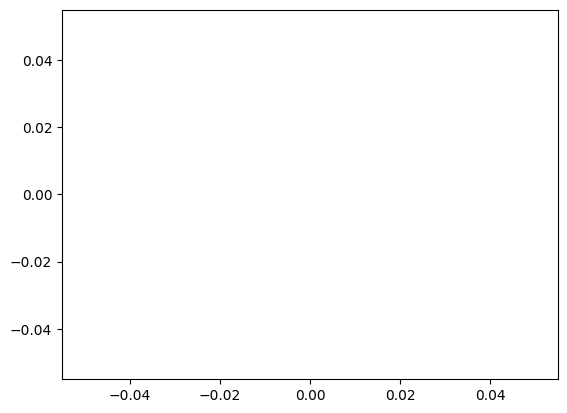

In [28]:
for acquire_percent in acquisition_strat:
    
    checkpoint_folder = os.path.join('active_checkpoint', acquire_method, str(tokens_acquired).zfill(8)).replace('\\', '/')
    checkpoint_path = os.path.join(result_path, model_name, checkpoint_folder).replace('\\', '/')
    if not os.path.exists(checkpoint_path):
        os.makedirs(checkpoint_path)
        
    acq_plot_every = max(len(acquisition_function.train_index)/(5*parameters['batch_size']), 1)
    losses, all_F = trainer.train_model(opt.num_epochs, active_train_data, dev_data, test_train_data, test_data,
                                        learning_rate=learning_rate, checkpoint_folder=checkpoint_folder,
                                        # batch_size=min(parameters['batch_size'],len(acquisition_function.train_index)/100),
                                        batch_size=parameters['batch_size'],
                                        eval_test_train=False, plot_every=acq_plot_every, lr_decay=0.05)
    
    pkl.dump(acquisition_function, open(os.path.join(checkpoint_path, 'acquisition1.p').replace('\\', '/'), 'wb'))
    acquisition_function.obtain_data(model_path=os.path.join(checkpoint_path, 'modelweights').replace('\\', '/'), model_name=model_name,
                                     data=train_data, acquire=acquire_percent, method=acquire_method)
    
    pkl.dump(acquisition_function, open(os.path.join(checkpoint_path, 'acquisition2.p').replace('\\', '/'), 'wb'))
    
    print('*'*80)
    saved_epoch = np.argmax(np.array([item[1] for item in all_F]))
    print('Budget Exhausted: %d, Best F on Validation %.3f, Best F on Test %.3f' % (tokens_acquired,
                                        all_F[saved_epoch][1], all_F[saved_epoch][2]))
    print('*'*80)
    
    active_train_data = [train_data[i] for i in acquisition_function.train_index]
    tokens_acquired = sum([len(x['words']) for x in active_train_data])
    
    plt.clf()
    plt.plot(losses)
    plt.savefig(os.path.join(checkpoint_path, 'lossplot.png').replace('\\', '/'))